In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import skimage
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = list(range(10))
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]

dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [4]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Import the model

In [5]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1
model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat,
    os.path.join(
        "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/",
        "mnist_continuous_alldigits/1/epoch_30_ckpt.pth"
    )
).to(DEVICE)

### Show generated digits

Sampling class: 0


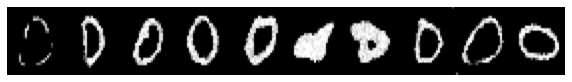

Sampling class: 1


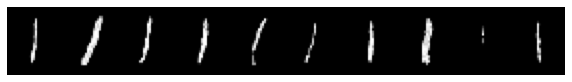

Sampling class: 2


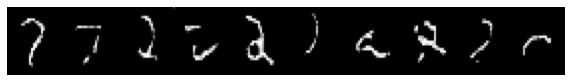

Sampling class: 3


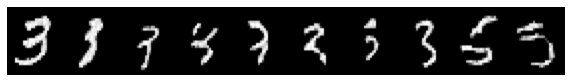

Sampling class: 4


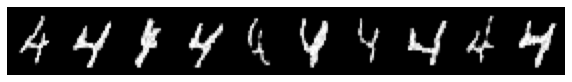

Sampling class: 5


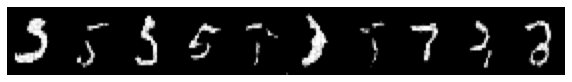

Sampling class: 6


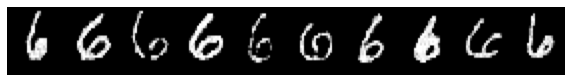

Sampling class: 7


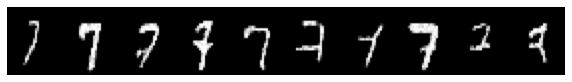

Sampling class: 8


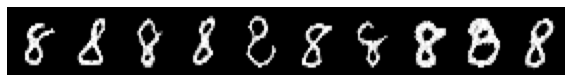

Sampling class: 9


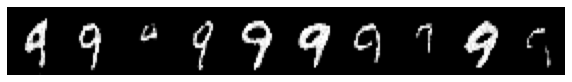

In [6]:
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit
    )
    plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 1), title=None)

**Intermediate states**

Branch point between 4 and 9


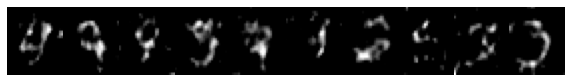

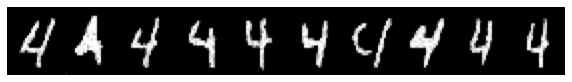

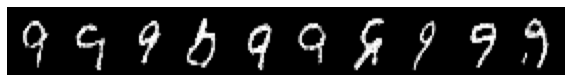

Branch point between 1 and 7


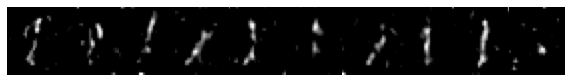

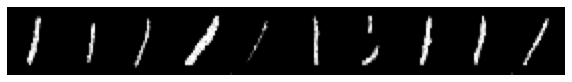

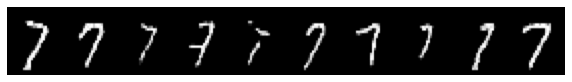

In [7]:
branch_point_examples = [
    (4, 9, 0.35235235235235235),
    (1, 7, 0.3743743743743744)
]

for class_1, class_2, branch_time in branch_point_examples:
    print("Branch point between %d and %d" % (class_1, class_2))
    samples_12 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc", t_start=branch_time,
        t_limit=t_limit
    ).cpu().numpy()
    samples_1 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time,
        initial_samples=torch.tensor(samples_12).to(DEVICE)
    ).cpu().numpy()
    samples_2 = generate.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time,
        initial_samples=torch.tensor(samples_12).to(DEVICE)
    ).cpu().numpy()

    smoothed_samples_12 = np.empty_like(samples_12)
    for i in range(len(samples_12)):
        smoothed_samples_12[i, 0] = scipy.ndimage.gaussian_filter(samples_12[i, 0], sigma=1)

    plot_mnist_digits(smoothed_samples_12)
    plot_mnist_digits(samples_1)
    plot_mnist_digits(samples_2)

**Diffusing from one class to another**

In [8]:
def binarize(x):
    mask = x > 0
    new_x = x.copy()
    new_x[mask] = 1
    new_x[~mask] = 0
    return new_x

def get_highest_slope(image, plot=False):
    """
    Given a NumPy-array image of shape H x W, gives the slope (m) of the
    steepest line found by the Hough transform.
    """
    acc, thetas, rhos = skimage.transform.hough_line(binarize(image))
    _, angles, dists = skimage.transform.hough_line_peaks(
        acc, thetas, rhos, min_angle=30
    )
    slopes = np.tan(angles + (np.pi / 2))
    
    if plot:
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.imshow(image, cmap="gray")
        ax.set_ylim((image.shape[0], 0))
        ax.set_axis_off()
        for i in range(len(slopes)):
            x, y = dists[i] * np.cos(angles[i]), dists[i] * np.sin(angles[i])
            ax.axline((x, y), slope=slopes[i])
        plt.show()
    
    return slopes[np.argmax(np.abs(slopes))]

Class 4 to 9


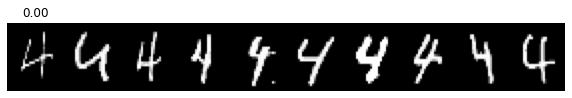

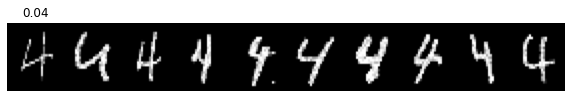

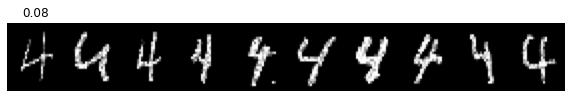

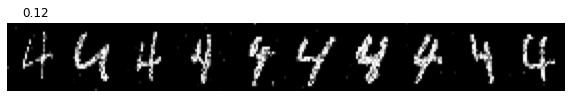

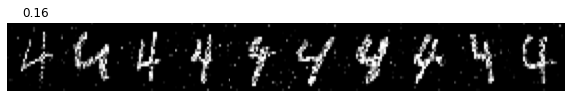

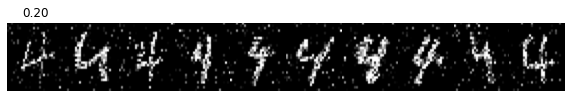

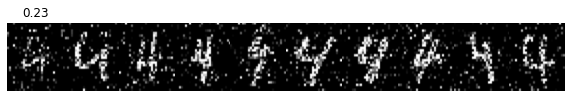

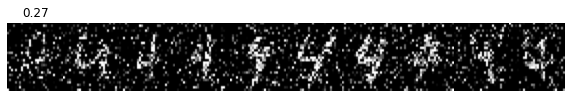

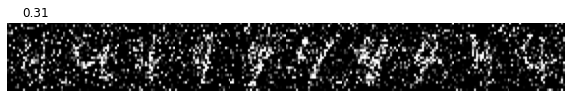

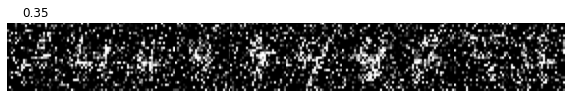

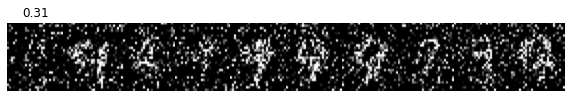

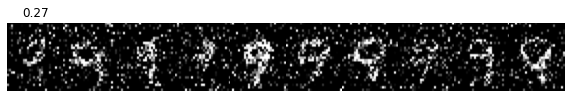

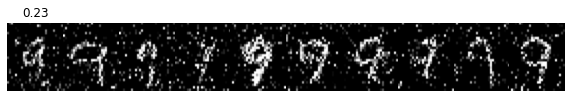

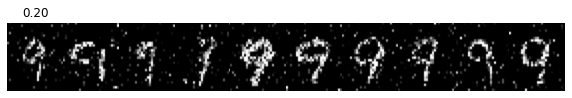

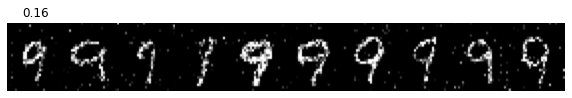

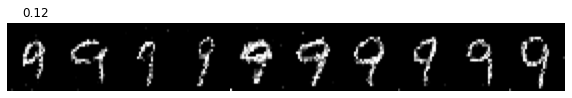

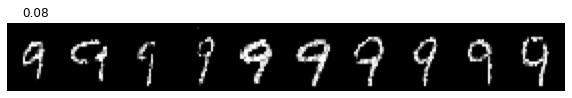

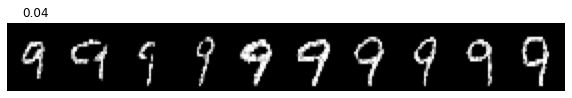

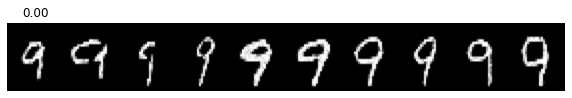

Class 9 to 4


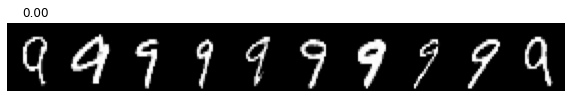

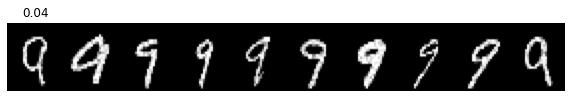

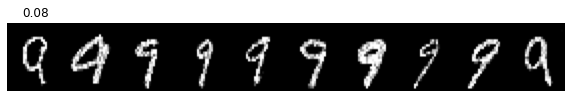

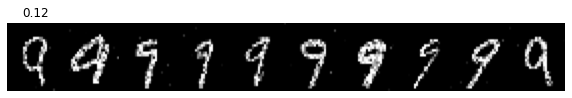

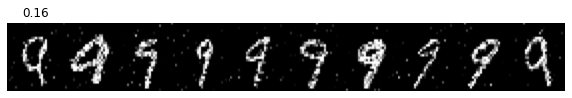

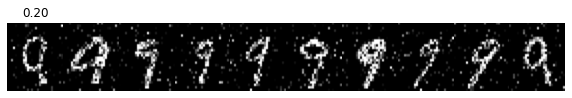

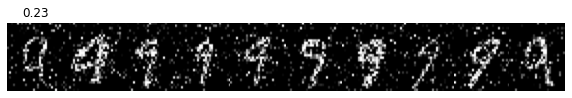

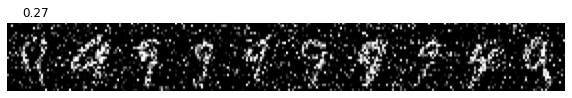

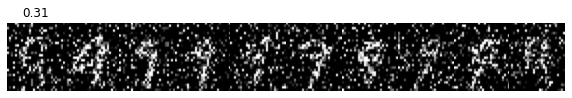

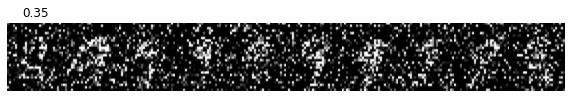

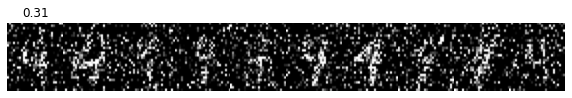

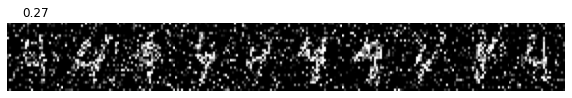

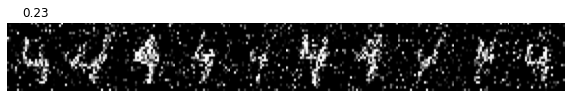

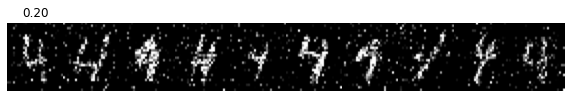

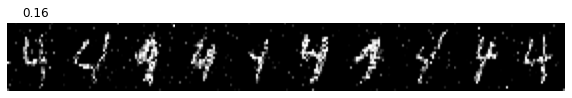

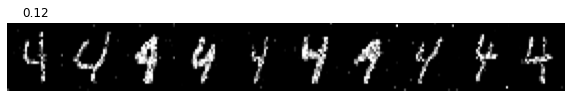

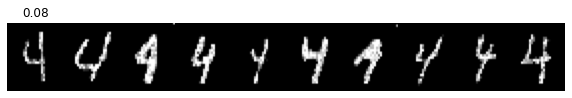

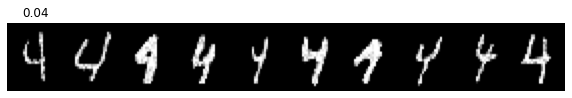

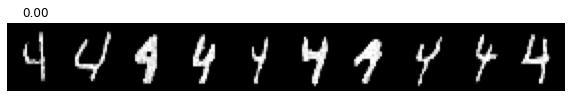

Class 1 to 7


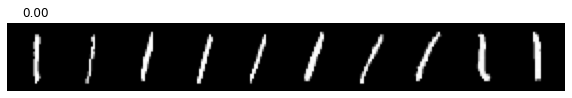

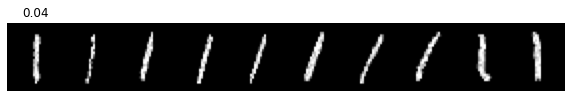

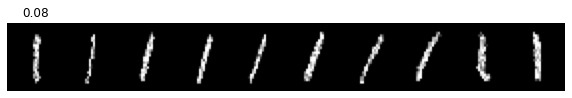

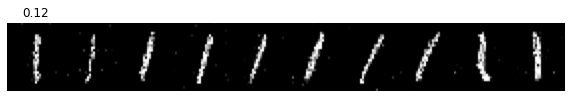

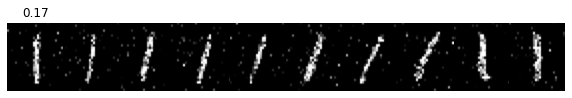

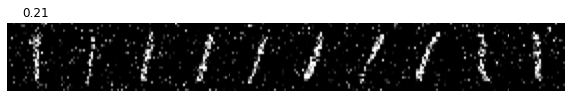

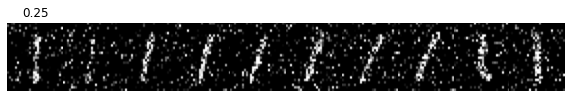

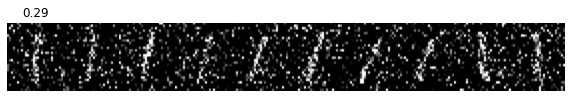

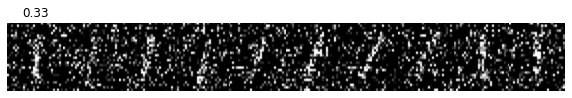

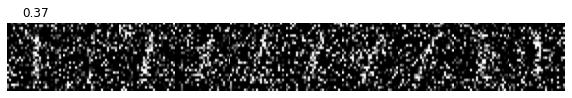

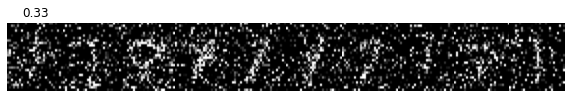

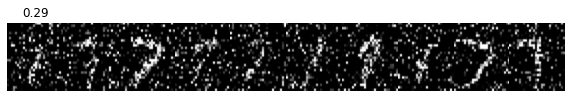

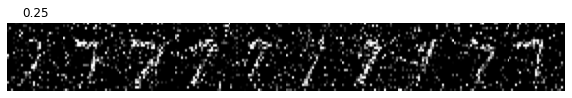

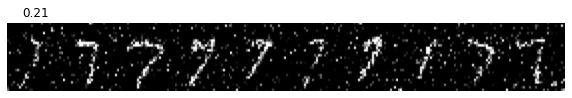

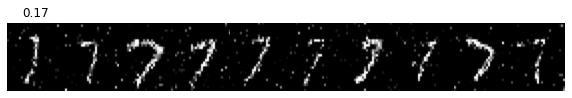

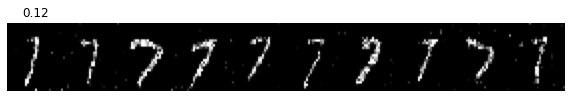

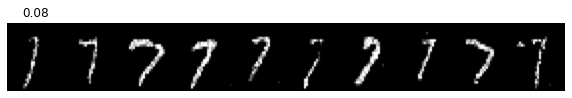

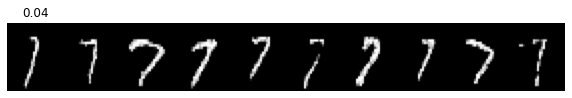

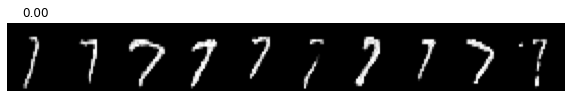

Class 7 to 1


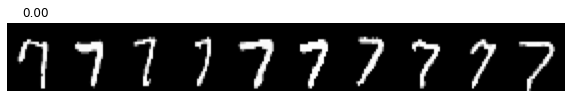

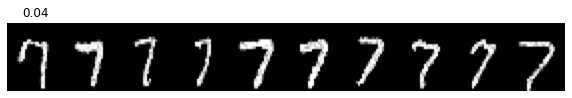

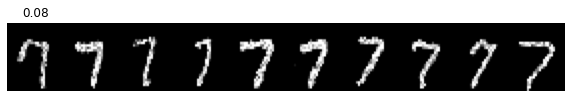

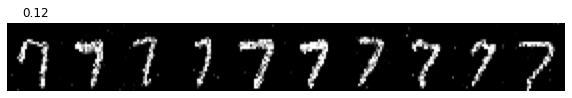

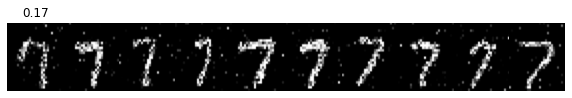

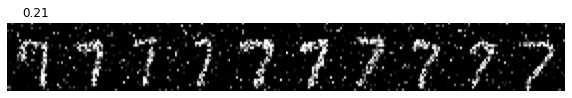

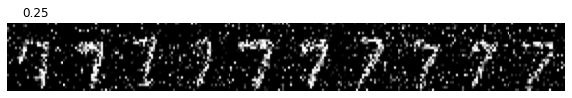

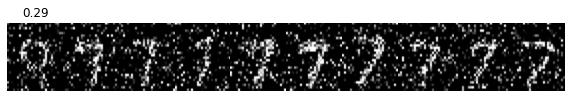

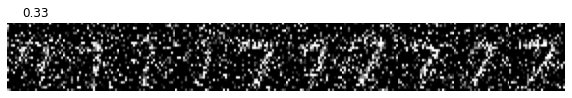

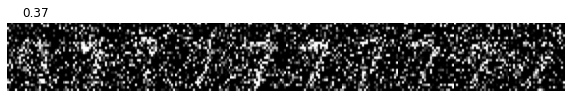

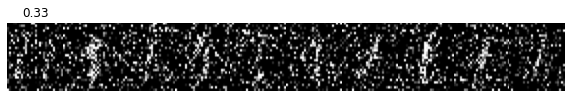

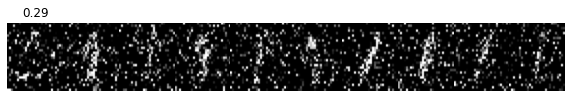

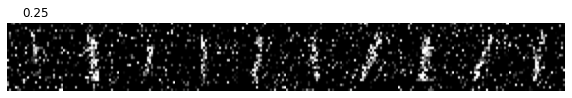

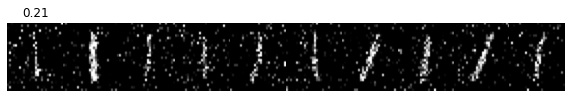

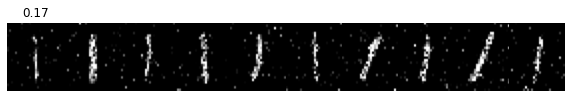

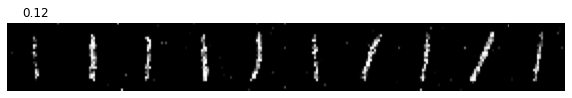

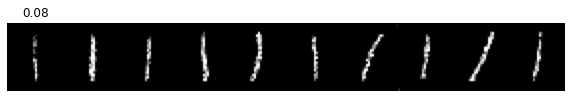

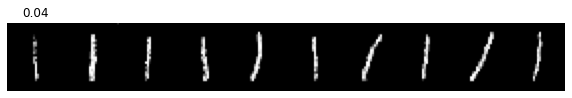

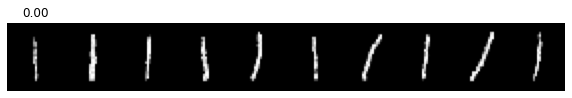

In [9]:
for class_1, class_2, branch_time in branch_point_examples:
    orig_1 = torch.stack([
        torch.tensor(dataset[i][0], device=DEVICE) for i in 
        np.random.choice(np.where(dataset.targets == class_1)[0], size=32, replace=False)
    ])
    orig_2 = torch.stack([
        torch.tensor(dataset[i][0], device=DEVICE) for i in 
        np.random.choice(np.where(dataset.targets == class_2)[0], size=32, replace=False)
    ])
    
    slopes_1 = np.array([get_highest_slope(obj[0]) for obj in orig_1.cpu().numpy()])
    slopes_2 = np.array([get_highest_slope(obj[0]) for obj in orig_2.cpu().numpy()])
    sample_inds_1 = np.argsort(slopes_1)[np.arange(0, len(slopes_1), len(slopes_1) // 10)]
    sample_inds_2 = np.argsort(slopes_2)[np.arange(0, len(slopes_2), len(slopes_2) // 10)]
    orig_1 = orig_1[sample_inds_1]
    orig_2 = orig_2[sample_inds_2]

    time_steps = 10
    all_t = np.linspace(0, branch_time, time_steps)
    forward_1_to_2 = np.empty((len(all_t),) + orig_1.shape)
    backward_1_to_2 = np.empty((len(all_t) - 1,) + orig_1.shape)
    forward_2_to_1 = np.empty((len(all_t),) + orig_1.shape)
    backward_2_to_1 = np.empty((len(all_t) - 1,) + orig_1.shape)
    for t_i, t in enumerate(all_t):
        forward_1_to_2[t_i] = sde.forward(
            orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
        )[0].cpu().numpy()
        forward_2_to_1[t_i] = sde.forward(
            orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
        )[0].cpu().numpy()

    all_t_flip = np.flip(all_t)
    last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
    last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
    for t_i in range(len(all_t_flip) - 1):
        last_1_to_2 = generate.generate_continuous_branched_samples(
            model, sde, class_2, class_time_to_branch_tensor, sampler="pc",
            t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
            num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
            num_steps=50
        )
        backward_1_to_2[t_i] = last_1_to_2.cpu().numpy()

        last_2_to_1 = generate.generate_continuous_branched_samples(
            model, sde, class_1, class_time_to_branch_tensor, sampler="pc",
            t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
            num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
            num_steps=50
        )
        backward_2_to_1[t_i] = last_2_to_1.cpu().numpy()

    print("Class %d to %d" % (class_1, class_2))
    for t_i, t in enumerate(all_t):
        plot_mnist_digits(forward_1_to_2[t_i], title=("%.2f" % t))
    for t_i, t in enumerate(all_t_flip[1:]):
        plot_mnist_digits(backward_1_to_2[t_i], title=("%.2f" % t))

    print("Class %d to %d" % (class_2, class_1))
    for t_i, t in enumerate(all_t):
        plot_mnist_digits(forward_2_to_1[t_i], title=("%.2f" % t))
    for t_i, t in enumerate(all_t_flip[1:]):
        plot_mnist_digits(backward_2_to_1[t_i], title=("%.2f" % t))